In [1]:
import Recomandation_models as rm
import Filtering as fl
import pandas as pd
import numpy as np

import math
from time import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist

### DATA PREPARATION

In [70]:
class Spatial_F_AE(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,50),
            nn.ReLU(),
            nn.Linear(50,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

In [63]:
def train(model, dataloader, criterion, optimizer, num_epochs, scheduler=None, best_loss=float('inf')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs = batch[0]
            inputs = inputs.to(device)
            recon = model(inputs)
            loss = criterion(recon, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step(loss.item())
            running_loss += loss.item()
        losses.append(running_loss / (i + 1))
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Loss = {running_loss / (i + 1):.4f}")
    return losses

In [123]:
df_books = pd.read_csv('books_autorec.csv')
df_books.sort_values(by='ratings_count', ascending=False, inplace=True)
df_books = df_books.iloc[:1000]
df_books.to_csv('Spatial_model_books.csv')
df_books['goodreads_book_id'] = df_books['goodreads_book_id'].astype(int)
book_ids = df_books['goodreads_book_id']


In [124]:
df_books = pd.read_csv('Spatial_model_books.csv')

In [125]:
df = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

df_ratings_with_clusters = df_ratings.merge(
    df[['goodreads_book_id', 'cluster']], 
    left_on='book_id', 
    right_on='goodreads_book_id', 
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in df_ratings_with_clusters.groupby('user_id'):
    books_ratings_clusters = group[['book_id', 'rating', 'cluster']].values.tolist()
    sparse_users[user_id] = books_ratings_clusters

cluster_sizes = df_books['cluster'].value_counts().sort_index().values

filter_users = {
    user: [triplet for triplet in triplets if triplet[0] in book_ids]
    for user, triplets in sparse_users.items()
}
filter_users = {user: triplets for user, triplets in filter_users.items() if triplets}
filter_users = sorted(filter_users.items(), key=lambda x: len(x[1]), reverse=True)[:10000]
filter_users = dict(filter_users)


In [126]:
print(len(sparse_users))
print(len(filter_users))

53424
10000


In [127]:
mapping_pos_to_books = dict(zip(range(1000), book_ids))
mapping_books_to_pos = dict(zip(book_ids,range(10000)))
mapping_pos_to_users = dict(zip(range(10000), filter_users.keys()))
mapping_users_to_pos = dict(zip(filter_users.keys(),range(10000)))
print(len(mapping_pos_to_books))
print(len(mapping_books_to_pos))
print(len(mapping_pos_to_users))
print(len(mapping_users_to_pos))

1000
1000
10000
10000


In [146]:
n_books = len(mapping_books_to_pos)
user_vectors = []
for user_id, triplets in filter_users.items():
    vector = np.zeros(n_books)  # inizializza vettore di zeri

    for book_id, rating, _ in triplets:
        if book_id in mapping_books_to_pos:  # se il book_id è tra quelli mappati
            index = mapping_books_to_pos[book_id]
            vector[index] = rating  # inserisci il rating nella posizione giusta

    user_vectors.append(vector)
print(len(user_vectors))
print(len(user_vectors[0]))
for i in range(len(user_vectors)):
    user_vectors[i] = [0 if elem < 3 else 1 for elem in user_vectors[i]]
print(user_vectors[0])
df_input_data = pd.DataFrame(user_vectors)

10000
1000
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [147]:
#df_input_data = pd.read_csv('Spatial_model_inputs.csv')
tensor_data = torch.tensor(df_input_data.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(tensor_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [148]:
model = rm.Spatial_F_AE(1000)
criterion = nn.MSELoss()
N_Epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False)

C:\Users\pitom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [149]:
losses = train(model,dataloader,criterion, optimizer, N_Epochs, scheduler)

Epoch 1: Loss = 0.0134
Epoch 2: Loss = 0.0049
Epoch 3: Loss = 0.0049
Epoch 4: Loss = 0.0049
Epoch 5: Loss = 0.0049
Epoch 6: Loss = 0.0048
Epoch 7: Loss = 0.0049
Epoch 8: Loss = 0.0048
Epoch 9: Loss = 0.0048
Epoch 10: Loss = 0.0048
Epoch 11: Loss = 0.0048
Epoch 12: Loss = 0.0048
Epoch 13: Loss = 0.0048
Epoch 14: Loss = 0.0048
Epoch 15: Loss = 0.0048
Epoch 16: Loss = 0.0048
Epoch 17: Loss = 0.0048
Epoch 18: Loss = 0.0048
Epoch 19: Loss = 0.0048
Epoch 20: Loss = 0.0048


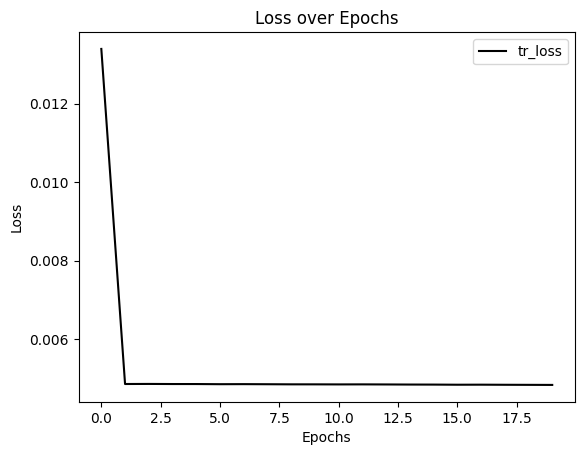

In [150]:
rm.loss_graph(losses, N_Epochs)

In [186]:
original = dataloader.dataset[0][0]
model.eval()
recon = model(original)
old_books= (original != 0).nonzero(as_tuple=True)[0].tolist()
_, new_books = torch.topk(recon, 25)
new_books = new_books.tolist()
print(len(new_books))
print(len(old_books))


25
17


In [187]:
old_books_map = [mapping_pos_to_books[pos] for pos in old_books]
new_books_map = [mapping_pos_to_books[pos] for pos in new_books]
print(old_books_map)
print(new_books_map)

[3, 960, 5, 34, 6, 2, 1, 890, 865, 11, 1202, 320, 33, 13, 350, 21, 830]
[2, 3, 5, 6, 1, 11, 34, 890, 960, 33, 865, 1202, 320, 305234, 39999, 15507958, 9418327, 662, 3869, 2156, 567616, 37190, 1097, 15717943, 295]


In [188]:
old_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in old_books_map]
new_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in new_books_map]
old_titles

["Harry Potter and the Philosopher's Stone",
 'Angels & Demons ',
 'Harry Potter and the Prisoner of Azkaban',
 ' The Fellowship of the Ring',
 'Harry Potter and the Goblet of Fire',
 'Harry Potter and the Order of the Phoenix',
 'Harry Potter and the Half-Blood Prince',
 'Of Mice and Men ',
 'O Alquimista',
 "The Hitchhiker's Guide to the Galaxy",
 'Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
 'Cien años de soledad',
 'The Lord of the Rings',
 "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story",
 'Stranger in a Strange Land',
 'A Short History of Nearly Everything',
 'Snow Crash']

In [189]:
new_titles

['Harry Potter and the Order of the Phoenix',
 "Harry Potter and the Philosopher's Stone",
 'Harry Potter and the Prisoner of Azkaban',
 'Harry Potter and the Goblet of Fire',
 'Harry Potter and the Half-Blood Prince',
 "The Hitchhiker's Guide to the Galaxy",
 ' The Fellowship of the Ring',
 'Of Mice and Men ',
 'Angels & Demons ',
 'The Lord of the Rings',
 'O Alquimista',
 'Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
 'Cien años de soledad',
 'Wicked Lovely ',
 'The Boy in the Striped Pyjamas',
 'Me Before You',
 'Bossypants',
 'Atlas Shrugged',
 'A Brief History of Time: From the Big Bang to Black Holes',
 'Persuasion',
 'The Art Book',
 ' The Tale of Despereaux',
 'Fast Food Nation : The Dark Side of the All-American Meal ',
 'Hopeless',
 'Treasure Island']

In [ ]:
diff = 

'Harry Potter and the Order of the Phoenix'